<img src="report_material/feup_logo_old.png" width="30%" align="center"/>

<h1 style="text-align:center">Neural Networks for the Prediction of Anuran Species (E3.)</h1>
<h3 style="text-align:center">Intermediate Report</h3>
<br/><br/>
<p style="text-align:center">Artificial Intelligence (IART)</p>
<p style="text-align:center">3<sup>rd</sup> year in Master in Informatics and Computing Engineering</p>

### Authors

* Miguel Ramalho    - 201403027 - [m.ramalho@fe.up.pt](mailto:up201403027@fe.up.pt)
* Rostyslav Khoptiy - 201500000 - [up201500000@fe.up.pt](mailto:up201500000@fe.up.pt)

<!--spellchecking: https://stackoverflow.com/a/48710561/6196010 -->

<div style="text-align:right"><i>April 8<sup>th</sup>, 2018</i></div>
<br/><br/><br/><br/><br/><br/>

---

# Goals
Descrição sumária do objetivo do trabalho

<cite data-cite="granger2013">(Granger, 2013)</cite>

((*- extends 'latex_article.tplx' -*))

((* block bibliography *))
\bibliographystyle{unsrt}
\bibliography{ipython}
((* endblock bibliography *))


# Description

## Especificação
Descrição pormenorizada do trabalho.

Descrição e análise do dataset. 

Pré-processamento dos dados.

Modelo de aprendizagem a aplicar: árvores de decisão / redes neuronais.


Redes neuronais: arquitectura, configuração prevista da rede.

## Trabalho Efectuado
Descrição do trabalho que já realizou.

## Resultados esperados e forma de avaliação
Enumere testes a definir para validar o resultado do trabalho

(falar de métricas tipo recall, precision, vizualizações que permitam analisar overfitting e underfitting)

# Conclusões
Escreva aqui as conclusões que achar devidas.

# Recursos
Indique os recursos usados na realização do trabalho: bibliografia e software.

In [1]:
import pandas as pd
import tensorflow as tf
import io # to pass data as StringIO object
import time # to set the random seed for train and test sampling

In [2]:
DATASET_PATH = "dataset/frogs.csv" # the path to the dataset file
CHECKPOINTS_PATH = "model_checkpoints" # folder that holds the Tensorflow checkpoints
N_FEATURES = 22 # the number of features in the dataset
LABEL_INDEX = 24 # the index in the dataset where the label to predict is
BATCH_SIZE = 100 # batch size for the train, evaluation and prediction
TRAIN_PERCENT = 0.8 # this means 80% of examples will be used for training and 20% for testing

In [3]:
# from csv to pandas Dataframe
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.replace(" ", "") # remove whitespace, needed for TF
print("Got %d examples from the .csv" % df.shape[0])
df.head()

Got 7195 examples from the .csv


,MFCCs_1,MFCCs_2,MFCCs_3,MFCCs_4,MFCCs_5,MFCCs_6,MFCCs_7,MFCCs_8,MFCCs_9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [4]:
# split into 80% train and 20% test, may need crossvalidation in the future
train=df.sample(frac=TRAIN_PERCENT, random_state=int(time.time()))
test=df.drop(train.index)

# split dataframes into X (features) and y (classes) - use species as label
train_x, train_y = train.iloc[:,:N_FEATURES], train.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
test_x, test_y = test.iloc[:,:N_FEATURES], test.iloc[:,LABEL_INDEX:LABEL_INDEX+1]

In [5]:
# Convert the features MFCCs_1 to MFCCs_22 into Tensorflow feature columns
my_feature_columns = [tf.feature_column.numeric_column(key=key) for key in list(train_x)]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model_checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D3D3607DD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


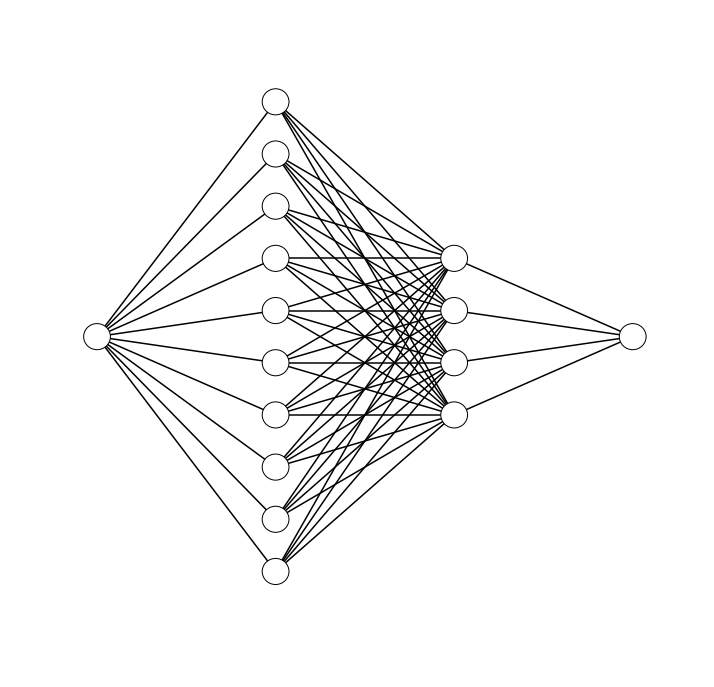

In [8]:
# Build a DNN (Deep Neural Network) with 1 hidden layer with 10 nodes
classifier = tf.estimator.DNNClassifier(
        feature_columns=my_feature_columns,
        hidden_units=[10],
        n_classes=10,
        model_dir=CHECKPOINTS_PATH) # 4 families, 8 genus, 10 species, 60 anurans
drawNN([1, 10, 4, 1])

In [9]:
def train_input_fn(features, labels):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle, repeat, and batch the examples. The shuffle argument should be larger than the number of examples
    return dataset.shuffle(df.shape[0] * 10).repeat().batch(BATCH_SIZE)

In [10]:
# converts a list of strings into a list of IDs (numerical values) used for the classifier
def convert_labels_to_number(labels):
    unique_labels = list(set(labels)) # list of unique values
    return unique_labels, [unique_labels.index(l) for l in labels]

In [11]:
# for the 10 species, get a numerical mapping of the text name of that species (needed for DNN)
_, numeric_train_y = convert_labels_to_number(train_y.iloc[:,0])
_, numeric_test_y  = convert_labels_to_number(test_y.iloc[:,0])

In [12]:
# Train the model - 10 steps
classifier.train(input_fn=lambda:train_input_fn(train_x, numeric_train_y), steps=1000)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_checkpoints\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1001 into model_checkpoints\model.ckpt.
INFO:tensorflow:loss = 348.27292, step = 1001
INFO:tensorflow:global_step/sec: 283.222
INFO:tensorflow:loss = 69.6325, step = 1101 (0.355 sec)
INFO:tensorflow:global_step/sec: 301.202
INFO:tensorflow:loss = 54.60155, step = 1201 (0.332 sec)
INFO:tensorflow:global_step/sec: 364.301
INFO:tensorflow:loss = 34.326942, step = 1301 (0.274 sec)
INFO:tensorflow:global_step/sec: 390.851
INFO:tensorflow:loss = 41.47987, step = 1401 (0.255 sec)
INFO:tensorflow:global_step/sec: 379.435
INFO:tensorflow:loss = 22.132345, step = 1501 (0.264 sec)
INFO:tensorflow:global_step/sec: 354.61
INFO:tensorflow:loss = 36.35704

## Evaluation

In [13]:
def eval_input_fn(features, labels=None):
    inputs = features if labels is None else (features, labels)
    
    # Convert inputs to a tf.dataset object. Batch the examples.
    dataset = tf.data.Dataset.from_tensor_slices(inputs).batch(BATCH_SIZE)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [14]:
# Evaluate the model.
eval_result = classifier.evaluate(input_fn=lambda:eval_input_fn(dict(test_x), numeric_test_y))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-03-17:37:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_checkpoints\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-03-17:37:23
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7303683, average_loss = 1.3766714, global_step = 2000, loss = 132.06868

Test set accuracy: 0.730



# Appendix functions
In this section we include functions that are directed at helping the visualisation of the project, and are not relevant for the proposed goals in any other way, so they need not be considered for evaluation

In [7]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    # https://gist.github.com/craffel/2d727968c3aaebd10359
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(max(len(layer_sizes) - 1, 1))
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

def drawNN(hidden_layers, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.axis('off')
    draw_neural_net(ax, .1, .9, .1, .9, hidden_layers)
    #fig.savefig('nn.png')
    

# IART

* [GitHub repository](https://github.com/msramalho/iart)
* [UCI source page](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29)
* [README](dataset/README.ipynb) of the dataset
* [Dataset file](dataset/frogs.csv)
* [Automatic Classification of Anuran Sounds Using Convolutional Neural Networks](report_material/papers/Automatic%20Classification%20of%20Anuran%20Sounds%20Using.pdf)
* [Tensorflow tutorial](https://www.tensorflow.org/get_started/premade_estimators)